
# Goal:
* Figure out why AP decreases with the number of probes
* Look at the combinations being tested
* Look at the distance values 
* Look at the coarse quantizer
* Look at our reconstruction methods
* Look at baseline methods -- are they sound? Are they making up numbers?

In [1]:
import os
import pickle
import json


import numpy as np
from importlib import reload

In [2]:
import random

import utils
import data
import search_concept
import search_expand

reload(utils)
reload(data)
reload(search_concept)
reload(search_expand)


# Index settings
dim = 512
k_coarse = 512
m = 8
nbits = 8
n_probes_list = [5, 10, 25, 50]
segments_to_test = 50

coco_path = '/data/users/jie/data-slicing/COCO/'
embed_path = '/data/users/jie/data-slicing/COCO/embeds/coco-2014-val-clip-embeds-532'
pickle_path = os.path.join(coco_path, 'embeds/coco-2014-val-clip-embeds-fast-2.pkl')
print(coco_path)
print(pickle_path)
if not os.path.exists(pickle_path):
    print('what')
    print(pickle_path)
embed_dict = utils.create_new_pickle(embed_path, pickle_path)



/data/users/jie/data-slicing/COCO/
/data/users/jie/data-slicing/COCO/embeds/coco-2014-val-clip-embeds-fast-2.pkl


In [83]:
import math

import utils
import data
import search_concept
import search_expand
import metrics

reload(utils)
reload(data)
reload(search_concept)
reload(search_expand)

times_np = []
times_roaring = []

mem_np = []
mem_roaring = []

def inner_loop(
        index_pq, index_flat_cpu, packd, img_concept_bitmap, 
        all_images, pqq, kmeans, n_probes, embed_dict, average_embeddings,
        n_segments_list):

    precision_results = {
        'our_roar_ap': [],
        'our_np_ap': [],
        'our_roar_ar': [],
        'our_np_ar': [],
        # 'pq_ap': [],
        # 'pq_ar': []
    }
    counter_results = {
        'our': [],
        'pq': []
    }

    # img_concept_bitmap = np.array([np.asfortranarray(img_concept_bitmap[:, i]) for i in range(img_concept_bitmap.shape[1])]).reshape(-1, 1)
    # for col_idx in range(img_concept_bitmap.shape[1]):
        # img_concept_bitmap[:, col_idx] = np.asfortranarray(img_concept_bitmap[:, col_idx])
    img_concept_bitmap = np.asfortranarray(img_concept_bitmap)

    # print('Number of segments:', n_segments_list)
    for n_segments in n_segments_list:
        random_img = random.choice(all_images)
        start_idx, end_idx, _ = embed_dict['img_to_vec_list'][random_img]
        img_embeddings = average_embeddings[start_idx:end_idx]
        random_embedding_idx = random.sample(range(len(img_embeddings)), min(n_segments, len(img_embeddings)))
        
        features = {f'v_{i}': img_embeddings[idx] for i, idx in enumerate(random_embedding_idx)}

        gt_images, _, gt_counter = search_expand.flat_multisearch(
            index_flat_cpu, features, p_k, vec_to_img, 
            max_search_radius=1e6, exclusive_matching=False)
        if len(gt_images) < p_k:
            continue

        # Run twice for warmup
        our_images_roar, _, our_counter, intersection_time, nbytes = search_concept.perform_search(
            features, p_k, kmeans, pqq, packd, img_concept_bitmap, all_images, 
            n_probes=n_probes, exclusive_matching=False, bitmap_mode='pyroaring')
        times_roaring.append(intersection_time)
        # our_images, _, our_counter, intersection_time, nbytes = search_concept.perform_search(
        #     features, p_k, kmeans, pqq, packd, img_concept_bitmap, all_images, 
        #     n_probes=n_probes, exclusive_matching=False, bitmap_mode='pyroaring')
        # times_roaring.append(intersection_time)
        mem_roaring.append(nbytes)

        our_images_np, _, our_counter, intersection_time, nbytes = search_concept.perform_search(
            features, p_k, kmeans, pqq, packd, img_concept_bitmap, all_images, 
            n_probes=n_probes, exclusive_matching=False, bitmap_mode=None)
        times_np.append(intersection_time)
        # our_images, _, our_counter, intersection_time, nbytes = search_concept.perform_search(
        #     features, p_k, kmeans, pqq, packd, img_concept_bitmap, all_images, 
        #     n_probes=n_probes, exclusive_matching=False, bitmap_mode=None)
        # times_np.append(intersection_time)
        mem_np.append(nbytes)

        # assert our_images_roar[:10] == our_images_np[:10], "Our images are not the same: " + str(our_images_roar[:10]) + "|" + str(our_images_np[:10])
        assert len(our_images_roar) == len(our_images_np), "Our images are not the same length: " + str(len(our_images_roar)) + "|" + str(len(our_images_np))


        pq_images, _, pq_counter = search_expand.flat_multisearch(index_pq, features, p_k, vec_to_img, 
            max_search_radius=1e6, exclusive_matching=False)

        # our_ap = utils.calculate_avg_precision(gt_images, our_images)
        # our_ap = str(utils.calculate_avg_precision(gt_images, our_images_roar)) + "|" + str(utils.calculate_avg_precision(gt_images, our_images_np))
        # pq_ap = utils.calculate_avg_precision(gt_images, pq_images)
        # our_ap = str(metrics._apk(gt_images, our_images_roar)) + "|" + str(metrics._apk(gt_images, our_images_np))
        # our_ar = str(metrics._ark(gt_images, our_images_roar)) + "|" + str(metrics._ark(gt_images, our_images_np))
        
        precision_results['our_roar_ap'].append(metrics._apk(gt_images, our_images_roar))
        precision_results['our_np_ap'].append(metrics._apk(gt_images, our_images_np))
        precision_results['our_roar_ar'].append(metrics._ark(gt_images, our_images_roar))
        precision_results['our_np_ar'].append(metrics._ark(gt_images, our_images_np))
        # precision
        # counter_results['pq'].append(pq_counter)
    
    return precision_results, counter_results

average_embeddings = embed_dict['average_embeddings']
all_precisions = {}
all_counts = {}
all_recalls = {}
for n_probes in n_probes_list:
    # train_sample_size = 10_000
    train_sample_size = int( 128 * math.sqrt(len(average_embeddings)))
    # data_sample_size = 10_000
    train_sample_size = None
    data_sample_size = None

    index_pq, index_flat_cpu, packd, img_concept_bitmap, all_images, pqq, kmeans = data.get_indices(
            dim=dim, k_coarse=k_coarse, m=m, cluster_bits=nbits, 
            n_probes=n_probes, embed_dict=embed_dict, use_custom_pq=False,
            random_seed=None, train_sample_size=train_sample_size,
            data_sample_size=data_sample_size
        )

    print(index_pq.nprobe, 'is number of nprobe i configured')

    all_images = list(embed_dict['img_to_vec_list'].keys())
    vec_to_img = embed_dict['vec_to_img']
    n_iterations = 10
    n_segments_list = [2, 4, 6]
    p_k = 10

    all_counts[n_probes] = {
        'our': [],
        'pq': []
    }

    all_precisions[n_probes] = {
        'our_roar_ap': [],
        'our_np_ap': [],
        'our_roar_ar': [],
        'our_np_ar': [],
        # 'pq_ap': [],
        # 'pq_ar': []
    }
    all_recalls[n_probes] = {
        'our_roar_ar': [],
        'our_np_ar': [],
        # 'pq_ar': []
    }

    for i in range(n_iterations):
        precisions, counts = inner_loop(
            index_pq, index_flat_cpu, packd, img_concept_bitmap, 
            all_images, pqq, kmeans, n_probes, embed_dict, average_embeddings,
            n_segments_list
        )
        # all_counts[n_probes]['our'].append(counts['our'])
        # all_counts[n_probes]['pq'].append(counts['pq'])

        all_precisions[n_probes]['our_roar_ap'].append(precisions['our_roar_ap'])
        all_precisions[n_probes]['our_np_ap'].append(precisions['our_np_ap'])
        all_recalls[n_probes]['our_roar_ar'].append(precisions['our_roar_ar'])
        all_recalls[n_probes]['our_np_ar'].append(precisions['our_np_ar'])

    print('Number of probes:', n_probes)
    print('Our precision:', np.mean(all_precisions[n_probes]['our_roar_ap']))
    print('PQ precision:', np.mean(all_precisions[n_probes]['our_np_ap']))
    # print('Our counter:', np.mean(all_counts[n_probes]['our']))
    # print('PQ counter:', np.mean(all_counts[n_probes]['pq']))
    print('')

for n_probes in n_probes_list:
    print('Number of probes:', n_probes)
    print('Our precision:', np.mean(all_precisions[n_probes]['our_roar_ap']))
    print('PQ precision:', np.mean(all_precisions[n_probes]['our_np_ap']))

    print('Our recall:', np.mean(all_recalls[n_probes]['our_roar_ar']))
    print('PQ recall:', np.mean(all_recalls[n_probes]['our_np_ar']))
    # print('Our counter:', np.mean(all_counts[n_probes]['our']))
    # print('PQ counter:', np.mean(all_counts[n_probes]['pq']))
    print('')


        


Building IVFPQ index


Building Flat index


WARNING clustering 512 points to 512 centroids: please provide at least 19968 training points


Kmeans trained (hax) 512


40501it [00:01, 39644.54it/s]


5 is number of nprobe i configured
Number of probes: 5
Our precision: 0.8750449735449735
PQ precision: 0.8750449735449735

Building IVFPQ index
Building Flat index


WARNING clustering 512 points to 512 centroids: please provide at least 19968 training points


Kmeans trained (hax) 512


KeyboardInterrupt: 

In [69]:
import numpy as np
import os
import pickle
from scipy import sparse
from pympler import asizeof
from pyroaring import BitMap


def bitmap_to_pyroaring(bitmap):
    """
    Convert a NumPy bitmap to PyRoaring bitmaps.
    
    Args:
        bitmap: A 2D NumPy boolean array
    
    Returns:
        List of PyRoaring BitMap objects, one for each column
    """
    n_rows, n_cols = bitmap.shape
    roarings = []
    
    for col in range(n_cols):
        # Find indices where column is True
        indices = np.where(bitmap[:, col])[0]
        
        # Create BitMap from indices (PyRoaring automatically converts to uint32)
        roaring = BitMap(indices)
        
        # Verification step
        original_count = np.sum(bitmap[:, col])
        assert len(roaring) == original_count, (
            f"Column {col} conversion mismatch! Original: {original_count}, "
            f"Roaring: {len(roaring)}"
        )
        
        roarings.append(roaring)
    
    return roarings


def measure_size_mb(obj):
    """Measure size of an object in MB using asizeof."""
    return asizeof.asizeof(obj) / (1024 * 1024)


def measure_pickle_size_mb(obj):
    """Measure serialized size of an object in MB using pickle."""
    return len(pickle.dumps(obj)) / (1024 * 1024)


def measure_npz_size_mb(sparse_matrix, filename="temp_sparse_matrix.npz"):
    """Measure serialized size of a sparse matrix in MB using npz format."""
    sparse.save_npz(filename, sparse_matrix)
    size_mb = os.path.getsize(filename) / (1024 * 1024)
    try:
        os.remove(filename)  # Clean up temp file
    except OSError:
        pass
    return size_mb


def calculate_sparse_data_size_mb(sparse_matrix):
    """Calculate the size of sparse matrix data in MB."""
    # Just return the size of the data array
    return sparse_matrix.data.nbytes / (1024 * 1024)


def calculate_roaring_size_mb(roarings):
    """Calculate the size of PyRoaring bitmaps in MB based on their statistics."""
    mem_keys = ['n_bytes_array_containers', 'n_bytes_run_containers', 'n_bytes_bitset_containers']
    total_bytes = 0
    
    for roaring in roarings:
        stats = roaring.get_statistics()
        for key in mem_keys:
            total_bytes += stats[key]
            
    return total_bytes / (1024 * 1024)


def compare_bitmap_representations(bitmap):
    """
    Compare different representations of a bitmap matrix.
    
    Args:
        bitmap: A 2D NumPy boolean array
    
    Returns:
        Dictionary with comparison results
    """
    results = {}
    
    # Original bitmap
    results["Original Bitmap"] = {
        "asizeof (MB)": measure_size_mb(bitmap),
        "pickle (MB)": measure_pickle_size_mb(bitmap)
    }
    
    # Convert to different sparse formats
    sparse_formats = {
        "CSR": sparse.csr_matrix(bitmap),
        "CSC": sparse.csc_matrix(bitmap),
        "COO": sparse.coo_matrix(bitmap),
        "BSR": sparse.bsr_matrix(bitmap),
        "LIL": sparse.lil_matrix(bitmap),
    }
    
    for format_name, sparse_matrix in sparse_formats.items():
        results[f"Sparse {format_name}"] = {
            "asizeof (MB)": measure_size_mb(sparse_matrix),
            "data only (MB)": calculate_sparse_data_size_mb(sparse_matrix),
            "pickle (MB)": measure_pickle_size_mb(sparse_matrix),
        }
        
        # NPZ size (only for formats that support it)
        if format_name in ["CSR", "CSC", "BSR"]:
            results[f"Sparse {format_name}"]["npz (MB)"] = measure_npz_size_mb(sparse_matrix)
    
    # Convert to PyRoaring
    roarings = bitmap_to_pyroaring(bitmap)
    results["PyRoaring"] = {
        "asizeof (MB)": measure_size_mb(roarings),
        "native stats (MB)": calculate_roaring_size_mb(roarings),
        "pickle (MB)": measure_pickle_size_mb(roarings)
    }
    
    return results


def print_comparison_results(results):
    """Print formatted comparison results."""
    print("\n===== COMPARISON OF BITMAP REPRESENTATIONS =====")
    
    # Find all metrics used across all representations
    all_metrics = set()
    for representation_data in results.values():
        all_metrics.update(representation_data.keys())
    all_metrics = sorted(list(all_metrics))
    
    # Print header
    header = "Format".ljust(15)
    for metric in all_metrics:
        header += metric.ljust(20)
    print(header)
    print("-" * (15 + 20 * len(all_metrics)))
    
    # Print data for each representation
    for representation, data in results.items():
        row = representation.ljust(15)
        for metric in all_metrics:
            if metric in data:
                row += f"{data[metric]:.4f}".ljust(20)
            else:
                row += "N/A".ljust(20)
        print(row)


# Example usage
# Create a sample bitmap for testing
test_bitmap = np.random.random((1000, 100)) > 0.9

# Run the comparison
results = compare_bitmap_representations(test_bitmap)

# Print results
print_comparison_results(results)

# To use with your img_concept_bitmap:
# results = compare_bitmap_representations(img_concept_bitmap)
# print_comparison_results(results)


===== COMPARISON OF BITMAP REPRESENTATIONS =====
Format         asizeof (MB)        data only (MB)      native stats (MB)   npz (MB)            pickle (MB)         
-------------------------------------------------------------------------------------------------------------------
Original Bitmap0.0955              N/A                 N/A                 N/A                 0.0955              
Sparse CSR     0.1012              0.0096              N/A                 0.0131              0.0522              
Sparse CSC     0.0980              0.0096              N/A                 0.0168              0.0488              
Sparse COO     0.0876              0.0096              N/A                 N/A                 0.0869              
Sparse BSR     0.1014              0.0096              N/A                 0.0131              0.0522              
Sparse LIL     0.0163              0.0076              N/A                 N/A                 0.0368              
PyRoaring      0.0219 

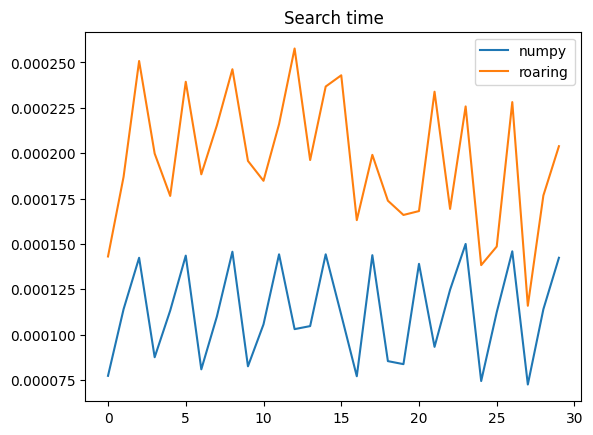

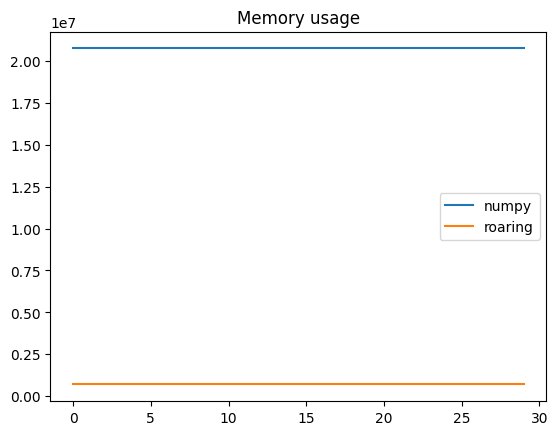

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

plt.title('Search time')
plt.plot(times_np, label='numpy')
plt.plot(times_roaring, label='roaring')
plt.legend()
plt.show()

plt.title('Memory usage')
plt.plot(mem_np, label='numpy')
plt.plot(mem_roaring, label='roaring')
plt.legend()
plt.show()

In [86]:
np.array(mem_np) / np.array(mem_roaring)

array([29.58318639, 29.58318639, 29.58318639, 29.58318639, 29.58318639,
       29.58318639, 29.58318639, 29.58318639, 29.58318639, 29.58318639,
       29.58318639, 29.58318639, 29.58318639, 29.58318639, 29.58318639,
       29.58318639, 29.58318639, 29.58318639, 29.58318639, 29.58318639,
       29.58318639, 29.58318639, 29.58318639, 29.58318639, 29.58318639,
       29.58318639, 29.58318639, 29.58318639, 29.58318639, 29.58318639])

In [85]:
min(np.array(times_np) / np.array(times_roaring))

0.3985728848114169

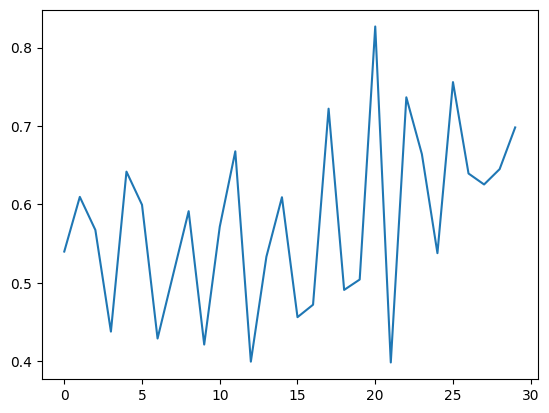

In [87]:
plt.plot(np.array(times_np) / np.array(times_roaring))

In [44]:
import pandas as pd

# del all_precisions[5]["our_roar_ar"]
# del all_precisions[5]["our_np_ar"]

pd.DataFrame(all_recalls[5])


,our_roar_ar,our_np_ar
0,"[0.27666666666666667, 0.24166666666666664, 0.5...","[0.27666666666666667, 0.24166666666666664, 0.5..."
1,"[0.16666666666666666, 0.1, 0.36269841269841263]","[0.16666666666666666, 0.1, 0.36269841269841263]"
2,"[0.5383333333333333, 0.1, 0.1]","[0.5383333333333333, 0.1, 0.1]"
3,"[0.22999999999999998, 0.38, 0.1]","[0.22999999999999998, 0.38, 0.1]"
4,"[0.1, 0.24285714285714283, 0.15833333333333333]","[0.1, 0.24285714285714283, 0.15833333333333333]"
5,"[0.2375, 0.1, 0.2]","[0.2375, 0.1, 0.2]"
6,"[0.1775, 0.1, 0.1]","[0.1775, 0.1, 0.1]"
7,"[0.5264285714285715, 0.19, 0.24285714285714288]","[0.5264285714285715, 0.19, 0.24285714285714288]"
8,"[0.29, 0.19, 0.1]","[0.29, 0.19, 0.1]"
9,"[0.1733333333333333, 0.55, 0.1]","[0.1733333333333333, 0.55, 0.1]"


In [5]:
import math
import random

import utils
import data
import search_concept
import search_expand
import numpy as np

reload(utils)
reload(data)
reload(search_concept)
reload(search_expand)

def inner_loop(
        index_pq, index_flat_cpu, packd, img_concept_bitmap, 
        all_images, pqq, kmeans, n_probes, embed_dict, average_embeddings,
        n_segments_list):

    precision_results = {
        'our': {n: [] for n in n_segments_list},
        'pq': {n: [] for n in n_segments_list}
    }
    counter_results = {
        'our': {n: [] for n in n_segments_list},
        'pq': {n: [] for n in n_segments_list}
    }
    for n_segments in n_segments_list:
        random_img = random.choice(all_images)
        start_idx, end_idx, _ = embed_dict['img_to_vec_list'][random_img]
        img_embeddings = average_embeddings[start_idx:end_idx]
        random_embedding_idx = random.sample(range(len(img_embeddings)), min(n_segments, len(img_embeddings)))
        
        features = {f'v_{i}': img_embeddings[idx] for i, idx in enumerate(random_embedding_idx)}

        gt_images, _, gt_counter = search_expand.flat_multisearch(
            index_flat_cpu, features, p_k, vec_to_img, 
            max_search_radius=1e6, exclusive_matching=False)
        
        if len(gt_images) < p_k:
            continue

        print('@@@@@ US @@@@@')
        our_images, _, our_counter = search_concept.perform_search(
            features, p_k, kmeans, pqq, packd, img_concept_bitmap, all_images, 
            n_probes=n_probes, exclusive_matching=False)
        print('@@@@@ PQ! @@@@@')
        pq_images, _, pq_counter = search_expand.flat_multisearch(
            index_pq, features, p_k, vec_to_img, 
            max_search_radius=1e6, exclusive_matching=False)
        print('-----------')

        print('GT images', gt_images)
        print('Our images', our_images)
        print('PQ images', pq_images)

        our_ap = utils.calculate_avg_precision(gt_images, our_images)
        pq_ap = utils.calculate_avg_precision(gt_images, pq_images)
        precision_results['our'][n_segments].append(our_ap)
        precision_results['pq'][n_segments].append(pq_ap)

        counter_results['our'][n_segments].append(our_counter)
        counter_results['pq'][n_segments].append(pq_counter)
    
    return precision_results, counter_results

n_probes_list = [25, 50]
average_embeddings = embed_dict['average_embeddings']
all_precisions = {}
all_counts = {}
n_segments_list = [4, 6]

print('Current Settings:')
print('Number of probes:', n_probes_list)
print('Number of segments:', n_segments_list)
print('K-coarse:', k_coarse)
print('M:', m)
print('N-bits:', nbits)
print('-----------')

def bitmap_to_sparse(bitmap):
    from scipy import sparse
    import pandas as pd
    sparse_mat = sparse.csr_matrix(bitmap)
    return pd.DataFrame.sparse.from_spmatrix(sparse_mat).values

for n_probes in n_probes_list:
    train_sample_size = int(128 * math.sqrt(len(embed_dict['img_to_vec_list'])))
    print(train_sample_size, 'is train sample size')
    # data_sample_size = 10_000
    data_sample_size = None
    # data_sample_size = None

    index_pq, index_flat_cpu, packd, img_concept_bitmap, all_images, pqq, kmeans = data.get_indices(
            dim=dim, k_coarse=k_coarse, m=m, cluster_bits=nbits, 
            n_probes=n_probes, embed_dict=embed_dict, use_custom_pq=False,
            random_seed=None, train_sample_size=train_sample_size,
            data_sample_size=data_sample_size
        )

    img_concept_bitmap = bitmap_to_sparse(img_concept_bitmap)

    print(index_pq.nprobe, 'is number of nprobe i configured')
    print('-----------')

    all_images = list(embed_dict['img_to_vec_list'].keys())
    vec_to_img = embed_dict['vec_to_img']
    n_iterations = 1
    p_k = 10

    all_counts[n_probes] = {
        'our': {n: [] for n in n_segments_list},
        'pq': {n: [] for n in n_segments_list}
    }

    all_precisions[n_probes] = {
        'our': {n: [] for n in n_segments_list},
        'pq': {n: [] for n in n_segments_list}
    }

    for i in range(n_iterations):
        precisions, counts = inner_loop(
            index_pq, index_flat_cpu, packd, img_concept_bitmap, 
            all_images, pqq, kmeans, n_probes, embed_dict, average_embeddings,
            n_segments_list
        )
        for n_segments in n_segments_list:
            all_counts[n_probes]['our'][n_segments].extend(counts['our'][n_segments])
            all_counts[n_probes]['pq'][n_segments].extend(counts['pq'][n_segments])
            all_precisions[n_probes]['our'][n_segments].extend(precisions['our'][n_segments])
            all_precisions[n_probes]['pq'][n_segments].extend(precisions['pq'][n_segments])

    print('Number of probes:', n_probes)
    for n_segments in n_segments_list:
        print(f'  Number of segments: {n_segments}')
        print(f'    Our precision: {np.mean(all_precisions[n_probes]["our"][n_segments])}')
        print(f'    PQ precision: {np.mean(all_precisions[n_probes]["pq"][n_segments])}')
        print(f'    Our counter: {np.mean(all_counts[n_probes]["our"][n_segments])}')
        print(f'    PQ counter: {np.mean(all_counts[n_probes]["pq"][n_segments])}')
    print('')

print("Overall results:")
for n_probes in n_probes_list:
    print('Number of probes:', n_probes)
    for n_segments in n_segments_list:
        print(f'  Number of segments: {n_segments}')
        print(f'    Our precision: {np.mean(all_precisions[n_probes]["our"][n_segments])}')
        print(f'    PQ precision: {np.mean(all_precisions[n_probes]["pq"][n_segments])}')
        print(f'    Our counter: {np.mean(all_counts[n_probes]["our"][n_segments])}')
        print(f'    PQ counter: {np.mean(all_counts[n_probes]["pq"][n_segments])}')
    print('')

Current Settings:
Number of probes: [25, 50]
Number of segments: [4, 6]
K-coarse: 512
M: 8
N-bits: 8
-----------
25759 is train sample size
Training on subset 0.052326443552892184
Building IVFPQ index
Building Flat index


WARNING clustering 512 points to 512 centroids: please provide at least 19968 training points


Kmeans trained (hax) 512


40501it [00:00, 55631.59it/s]
/tmp/ipykernel_2756724/1144895585.py:85: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  return pd.DataFrame.sparse.from_spmatrix(sparse_mat).values


25 is number of nprobe i configured
-----------
PQ: Number of candidates 23
PQ: Sorted images ['COCO_val2014_000000472762.jpg', 'COCO_val2014_000000026518.jpg', 'COCO_val2014_000000461681.jpg', 'COCO_val2014_000000056013.jpg', 'COCO_val2014_000000543686.jpg', 'COCO_val2014_000000059108.jpg', 'COCO_val2014_000000578964.jpg', 'COCO_val2014_000000449976.jpg', 'COCO_val2014_000000534178.jpg', 'COCO_val2014_000000362482.jpg']
@@@@@ US @@@@@
Query 0 w/: (25,)
Query 1 w/: (25,)
Query 2 w/: (25,)
Query 3 w/: (25,)
Key v_0 maps to concepts 25
Key v_1 maps to concepts 25
Key v_2 maps to concepts 25
Key v_3 maps to concepts 25
US: Number of matching images 3915
US: Distances {36993: 1.0642732828855515, 38832: 1.063895121216774, 27396: 1.0617684870958328, 7967: 1.059973806142807, 8866: 1.0594891458749771, 32908: 0.6072703301906586, 16198: 1.0061443150043488, 7527: 1.021084040403366, 39073: 1.0441927909851074, 20706: 1.0499426871538162}
US: Sorted images ['COCO_val2014_000000472762.jpg', 'COCO_val2

WARNING clustering 512 points to 512 centroids: please provide at least 19968 training points


Kmeans trained (hax) 512


40501it [00:00, 50115.52it/s] 


50 is number of nprobe i configured
-----------
PQ: Number of candidates 23
PQ: Sorted images ['COCO_val2014_000000221882.jpg', 'COCO_val2014_000000425933.jpg', 'COCO_val2014_000000027917.jpg', 'COCO_val2014_000000048972.jpg', 'COCO_val2014_000000503252.jpg', 'COCO_val2014_000000176193.jpg', 'COCO_val2014_000000373060.jpg', 'COCO_val2014_000000004359.jpg', 'COCO_val2014_000000493815.jpg', 'COCO_val2014_000000245481.jpg']
@@@@@ US @@@@@
Query 0 w/: (50,)
Query 1 w/: (50,)
Query 2 w/: (50,)
Query 3 w/: (50,)
Key v_0 maps to concepts 50
Key v_1 maps to concepts 50
Key v_2 maps to concepts 50
Key v_3 maps to concepts 50
US: Number of matching images 13031
US: Distances {20648: 0.9455460906028748, 7222: 0.936696320772171, 28008: 0.9382471740245819, 3876: 0.9149557203054428, 34336: 0.9110195487737656, 34352: 0.9252044409513474, 26864: 0.894716203212738, 32161: 0.8721569776535034, 15484: 0.5880171060562134, 1994: 0.9082971662282944}
US: Sorted images ['COCO_val2014_000000221882.jpg', 'COCO_va

In [6]:
print("Overall results:")
for n_probes in n_probes_list:
    print('Number of probes:', n_probes)
    for n_segments in n_segments_list:
        print(f'  Number of segments: {n_segments}')
        print(f'    Our precision: {np.mean(all_precisions[n_probes]["our"][n_segments])}')
        print(f'    PQ precision: {np.mean(all_precisions[n_probes]["pq"][n_segments])}')
        print(f'    Our counter: {np.mean(all_counts[n_probes]["our"][n_segments])}')
        print(f'    PQ counter: {np.mean(all_counts[n_probes]["pq"][n_segments])}')
    print('')

Overall results:
Number of probes: 25
  Number of segments: 4
    Our precision: 0.1
    PQ precision: 0.1
    Our counter: 41016.0
    PQ counter: 144623.0
  Number of segments: 6
    Our precision: 0.3930952380952381
    PQ precision: 0.2
    Our counter: 56301.0
    PQ counter: 197740.0

Number of probes: 50
  Number of segments: 4
    Our precision: 0.19285714285714287
    PQ precision: 0.16666666666666666
    Our counter: 169357.0
    PQ counter: 274156.0
  Number of segments: 6
    Our precision: 0.1
    PQ precision: 0.1
    Our counter: 275012.0
    PQ counter: 430354.0



In [2]:
import faiss
import numpy as np
from faiss.contrib.datasets import SyntheticDataset

ds = SyntheticDataset(32, 2000, 1000, 5)

index2 = faiss.index_factory(ds.d, "OPQ4,IVF100,PQ4x8np") 

In [4]:
# manually train the pretransform 
vt = faiss.downcast_VectorTransform(index2.chain.at(0))
vt.train(ds.get_train())

xt_transformed = vt.apply(ds.get_train())

# train the coarse quantizer
index_ivf = faiss.downcast_index(index2.index)
km = faiss.Kmeans(index_ivf.d, index_ivf.nlist, niter=index_ivf.cp.niter)
km.train(xt_transformed)
index_ivf.quantizer.add(km.centroids)   
# after k-means the centroids are added to the quantizer. This applies also to more complex quantizers like HNSW 

# train the PQ quantizer
index_ivf.train(xt_transformed)

WARNING clustering 2000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 2000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 2000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 2000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 2000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 2000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 2000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 2000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 2000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 2000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 2000 points to 256 centroids: please prov

In [11]:

km2 = faiss.Kmeans(index_ivf.d, index_ivf.nlist, niter=index_ivf.cp.niter)
km2.index.add(km.centroids)


In [17]:
index_ivf.quantizer.reconstruct_n(0, index_ivf.nlist)

array([[ 0.12838224, -0.02205496, -0.03139551, ...,  0.32923406,
         0.3375791 ,  0.3094011 ],
       [ 1.1718087 ,  0.39742315, -0.08726905, ..., -0.26676318,
        -0.42020518,  0.28959188],
       [ 0.00748609, -0.8629916 ,  0.09527918, ...,  0.37539458,
        -0.41916823, -0.11089257],
       ...,
       [ 0.35465205, -0.97603154, -0.05479439, ..., -1.4664073 ,
        -0.25075674,  0.17634328],
       [-1.0891715 ,  0.02416217,  0.15296915, ...,  0.97292536,
         0.8763622 , -0.24081537],
       [ 0.4350278 , -0.35931984,  0.483309  , ..., -0.5475069 ,
        -0.23947744,  0.32009158]], dtype=float32)